In [1]:
## BASICS
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle, Wedge, Polygon
from IPython.display import display, HTML

## DSP
! pip install control
! pip install audiolazy
! pip install PyDynamic
from PyDynamic.identification.fit_filter import LSIIR
from scipy import signal, fftpack
import control
import cmath
import sympy


/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_filter.py:29: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new module *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_transfer.py:28: DeprecationWarning: The package *identification* will be combined with the package *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new package *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/uncertainty/interpolation.py:28: PendingDeprecationWarning: The module :mod:`PyDynamic.uncertainty.interpolation` will be renamed to :mod:`PyDynamic.uncertainty.interpolate` in the next major release 2.0.0. From version 1.4.3 on you should 

In [2]:
sns.set_style("darkgrid")

# **PART 4 🇸- Linear Time Invariant (LTI) System**
## **AGENDA**
## > **1st METHOD (manual)** : Given transfer function $H(z)$ find **impulse response** $h[n]$ and **frequency respponse** $H(e^{jΩ})$

## > **2nd METHOD (simulation)** : Given 3 different delta inputs $x[n] = \delta[n]$, find 
## >> **responses** $y[n]=h[n]*x[n]$ 
## >> **frequency responses** $Y(e^{jΩ}) = H(e^{jΩ}) \cdot X(e^{jΩ}) = H(e^{jΩ})$
---

## 0. Utility Functions

In [3]:
def db(x):
  return 20 * np.log10(np.abs(x) / np.abs(x).max())
  
def display_tf(b, a, mode):
  b = [round(x,3) for x in b]
  a = [round(x,3) for x in a]
  if mode == "inverse" :  b = b[::-1] ; a = a[::-1]
  print()
  print(" "* 7, end = " ")
  print(b[0], end = " ")
  for z_idx in range(1, len(b)):
    if b[z_idx] > 0 : print("+", end = " ")
    if mode == "inverse" :
      print("{}z^({}) ".format(b[z_idx], -z_idx), end = " ")
    else:
      print("{}z^({}) ".format(b[z_idx], z_idx), end = " ")
    
  print()
  print("H(z) = " + "-"*max( len(b), len(a) ) * 13)
  print(" "* 7, end = " ")
  print(a[0], end = " ")
  for z_idx in range(1, len(a)):
    if a[z_idx] > 0 : print("+", end = " ")
    if mode == "inverse" :
      print("{}z^({}) ".format(a[z_idx], -z_idx), end = " ")
    else:
      print("{}z^({}) ".format(a[z_idx], z_idx), end = " ")
  print()
  print()

def plot_response(y, exponent = None, N  = 100, dbScale = False, name = "", color = "b") :
  n = np.arange(N)
  if dbScale : y = y = db(np.abs(y))
  fig, ax = plt.subplots(figsize = (10,6))
  ax.stem(n, y, linefmt = '-{}'.format(color),  markerfmt = '{}o'.format(color), label = r"Output Signal $y[n]$")
  if exponent is not None: plt.plot(n, 1.7368*(exponent)**n, "r--")
  ax.set_title(r"LTI : Input ${}$ / Output y[n]".format(name), size = 16, style = 'italic')
  ax.set_xlabel('Discrete-time index [n]', fontsize = 12)
  ax.set_ylabel('Amplitude',  fontsize = 12, color = "b")
  ax.grid(True, color = 'gray', alpha = 0.5)
  ax.legend(fancybox = True, prop = {'size': 15})
  plt.show()

def plot_freq_response(w, Y,  method = ""):
  magnitude = db(abs(Y))
  angles    = np.unwrap(np.angle(Y))
  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  plt.title(method + r' Digital filter frequency response $H(e^{jΩ})$')
  plt.plot(w, magnitude , 'b', label = "magnitude (1st Method)")
  plt.ylabel('Amplitude [dB]', color='b')
  plt.xlabel('Normalized Frequency [rad/sample]')
  ax2 = ax1.twinx()
  plt.plot(w, angles, 'g')
  plt.ylabel('Angle (radians)', color = 'g')
  plt.grid()
  plt.axis('tight')
  plt.show()


def plot_pole_zero(zeros, poles, ROC, lim = 6):

  fig, ax = plt.subplots(figsize = (10, 10))
  circle = plt.Circle((0, 0), radius = 1, color = 'b', linestyle = '--', linewidth = 1, fill = False, label = r"Unit Circle $|z| = 1$")
  ax.add_patch(ROC)
  ax.add_patch(circle)
  colors = ["b", "r"]
  for z, c in zip(*[zeros, colors]) :
    ax.scatter(z.real,z.imag, color = c , marker = 'o', s = 100, label = "Zeros")
  for p, c in zip(*[poles, colors]) :
    ax.scatter(p.real,p.imag, color = c , marker = 'x', s = 100, label = "Poles")
  ax.axhline(y = 0, xmin = -5.0, xmax = 5.0, color='blue', linestyle = '--',alpha = 0.2)
  ax.axvline(x = 0, ymin = -5.0, ymax = 5.0, color='blue', linestyle = '--',alpha = 0.2)
  ax.set_title(r"Pole-Zeros Map & ROC", size = 16, style = 'italic')
  ax.set_xlabel('Real Part (Re)', fontsize = 12)
  ax.set_ylabel('Imaginary Part (Im)', fontsize = 12)
  ax.set_xlim(-lim,lim)
  ax.set_ylim(-lim,lim)
  ax.grid(True, color = 'gray', alpha = 0.5)
  ax.legend(fancybox = True, prop = {'size': 15})
  plt.show()


## 1. Define the **Transfer Function** $H(z)$ of the LTI system (**discrete freq domain**) & ROC/Zero-Pole Map

### 1a. Transfer Function $H(z)$
$$H(z)= \frac{0.9474 + 0.2105z^{−1} − 0.7368z^{-2}}{1 − 1.579z^{−1} +0.7895z^{−2}}$$

### 1b. ROC & Zero-pole Map

* *Poles & Zeros*
  * **Poles** $z \in \{ 0.79 + 0.41j, 0.79 - 0.41j\}$
  * **Zeros** $z \in \{ -0.11 + 0.87 j, -0.11 - 0.87j\}$

* *ROC* : For that transfer function, you have 2 regions of convergence (ROCs) (which not include the coressponding 2 poles) 
  * $R_1 = \{|𝑧| > 0.888\}$ : 1) **Stability** : This ROC includes the unit circle $|z| = 1$, so the respective impulse response $h[n]$ corresponds to a **BIBO-stable filter** 2)**Causality** : Since it is an outer disk, the impulse response $h[n]$ will be **right-sided** and the system will be **causal**

  * $R_2 = \{|𝑧| < 0.888\}$ : 1) **Stability** : This ROC does not include the unit circle $|z| = 1$, so the respective impulse response $h[n]$  correspond to an **unstable filter** 2)**Causality** : Since it is an inner disk, the impulse response $h[n]$ will be **left-sided** and the system will be **anti-causal**



        0.737 + 0.21z^(-1)  + 0.947z^(-2)  
H(z) = ---------------------------------------
        0.789 -1.579z^(-1)  + 1z^(-2)  



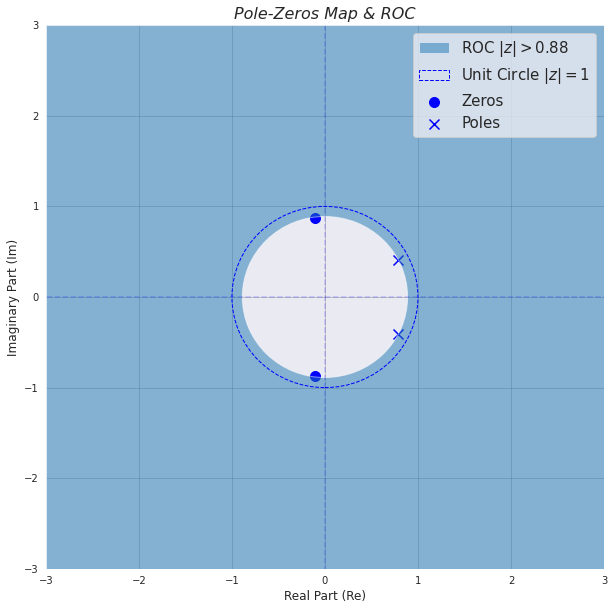

In [4]:
## 1a. Define the Transfer Function H
b = [ 0.9474, 0.2105, 0.7368]
a = [1, -1.579, 0.789]
H = signal.TransferFunction(b,a)
display_tf(b,a, "inverse")

## 1b. Plot zero-pole map & ROC
zeros, poles, _ = signal.tf2zpk(b, a)
roc = Wedge((0,0), 5, 0, 360, width = 4.111, alpha = 0.5, label = r"ROC $|z| > 0.88$")
plot_pole_zero([ zeros ],[ poles ], roc, lim = 3)


## 2. Find **Frequency Response** $H(e^{jΩ})$ (Magnitude $|H(e^{jΩ})|$, Phase $\angle H(e^{jΩ})$) (**continuous freq domain**)

* We will use the function `plot_freq_response()` we implemented before. This function used the function `scipy.signal.freqz` to find the $H(ω)$ and the respective padded angle range (normalized frequency) $ω \in (0, \pi)$

* **MAGNITUDE**
  * **POLES** : The poles are at $z_{p} = \{ 0.89 e^{j0.479}, 0.89 e^{-j0.479}\}$. Their presence at $\omega = \pm 0.479 rad/sample$ (**pass frequency**) will increase the **magnitude** of the spectrum around those normalized frequencies. We will see that the impulse response is a decreasing cosine signal, making the system a **decreasing oscillator**. So the formula will be $h[n] = gain \cdot a^{n} cos(\pi n)u[n]$. We will see that $a = 0.888$. When $a$ is small, the **mangitude increasing** we talked about will be smoother and less, since the poles are farer from the unit circle, while for bigger $a$ values (like here 0.888), the **mangitude increasing** it is sharper and hugier, since the poles are closer to the unit circle.

  * **ZEROS** : Moreover the zeros are at $z_{z} = \{ 0.88 e^{j1.697}, 0.88 e^{-j1.697}\}$. Their presence at $\omega = \pm 1.697 rad/sample$ (**stop frequency**) will decreases the **magnitude** of the spectrum around those normalized frequencies. 

* **PHASE**
A BIBO stable filter must have its poles within the unit circle, and as such in order to get linear phase, an **IIR filter** would need conjugate reciprocal poles outside of the unit circle, making it BIBO unstable. Based upon this statement, it would seem that it’s not possible to design an IIR to have linear phase. We see here that our phase is an **inversed parabolic function** of $\omega$


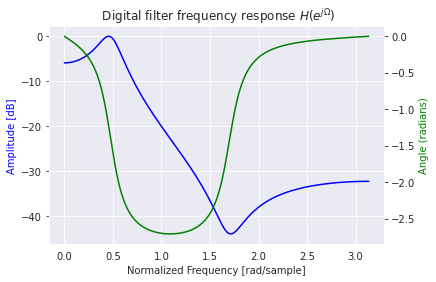

In [5]:
## 2. Find impulse response H(e^{jΩ})
w, Y = signal.freqz(b, a)
plot_freq_response(w, Y)

## 3. Find **Impulse Response** $h[n]$ of the LTI system

### **1st Method** (Inverse Z-Transform)
$$h[n] = \mathcal{Z}^{-1}\{H(z)\}$$ 

$$H(z) = \frac{ 0.9474z^{2}  +  0.2105z −0.7368}{(z - 0.7895 - 0.40766j)(z - 0.7895 + 0.40766j)} = \frac{A}{z - 0.7895 - 0.40766j} + \frac{B}{z - 0.7895 + 0.40766j} $$

After calculations we conclude that
$$0.9474z^{2} +  0.2105z −0.7368 = A(z - 0.7895 + 0.40766j) + B (z - 0.7895 - 0.40766j)$$
* $z = 0.7895 + 0.4076j \longrightarrow A = 0.8524 + 0.1672j$
* $z = 0.7895 - 0.4076j \longrightarrow B = 0.8524 - 0.1672j$ 


$$H(z) = 0.869e^{-j0.1937}\frac{1}{1 - 0.888e^{j0.476}z^{-1}} + 0.869e^{j0.1937}\frac{1}{1 - 0.888e^{-j0.476}z^{-1}}$$

By applying the inverse z-transform we have

$$h[n] = 0.869e^{-j0.1937} (0.888e^{j0.476})^{n}u[n] + 0.869e^{j0.1937}(0.888e^{-j0.476})^{n}u[n] \rightarrow$$

$$h[n] = 1.738 \left( \frac{e^{j(0.476n - 0.1937)} + e^{-j(0.476n - 0.1937)} }{2} \right)u[n] \longrightarrow$$

$$h[n] = 1.738\cdot (0.888)^{n} cos(0.476n - 0.194)u[n]$$

From this **impulse response** we see that our systel is a **damped oscillator** (modelled by a exponentially-decaying cosinusoidal term $(0.888)^{n}$.  We see that this is very similar to the undamped case $x[n] = A \cos (\omega_0 n +\phi)$, the key differences is that the frequency is small and  there is an overall exponential damping term.


### **2nd Method** (Simulate/Approximate $h[n]$ with different delta inputs $x[n]$ )
With this method we try to simulate and estimate $h[n]$ and $H(e^{jΩ})$ in an empirical manner.
$$Y(z) = Η(z)X(z) \Longrightarrow y[n] = h[n] * \delta[n]$$
* Input $x_1[n] = \delta[n] \quad 1 \leq n \leq 11$ ($L = 11$)

* Input $x_2[n] = \delta[n] \quad 1 \leq n \leq 51$ ($L = 51$)

* Input $x_3[n] = \delta[n] \quad 1 \leq n \leq 201$ ($L = 201$)

We can conclude on the following
* **IMPULSE RESPONSE $y[n] = h[n]$ (time domain)**
  * The use of **more samples** simulates better the performance of the manual h[n] we calculated before.

* **FREQUENCY RESPONSE $Y(e^{jΩ}) = Η(e^{jΩ})$ (frequency domain)** 
  * First and foremost, we **can not** use the in-built function `scipy.signal.freqz()` because its arguments are the `b,a`. Instead we should manually find the response. In this terms we use once again the `fftpack.fft()` approach (taking the half the samples because it is symmetrical  $\frac{L}{2}$)to simulate the response. 
  * Since we analyze the $ Η(e^{jΩ})$, it is a filter, an almost low pass filter, but not the best in cutting off higher frequencies. Having as a basis the $ Η(e^{jΩ})$ calculated before by using the `scipy.signal.freqz()` function, we seek to understand the role of $L$ in creating a manual $ Η(e^{jΩ})$ that behaves in the same way. We see that when **samples increase the behavior tends to be more similar. In fact for $L = 201$ the 2 filters are identical (both in terms of magnitude & angle)**.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


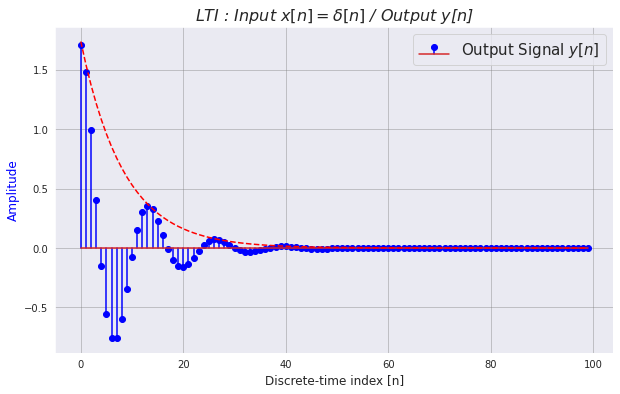

In [6]:
## 3. Computer the impulse response h[n]
# [*] 1st METHOD : Manual✅
L = 100
n = np.arange(L)
h = 1.738 * (0.888)**n * np.cos(0.476*n - 0.194) *  np.heaviside(n, 1)
plot_response(y = h, exponent = 0.888, N  = L , dbScale = False, name = "x[n] = δ[n]")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


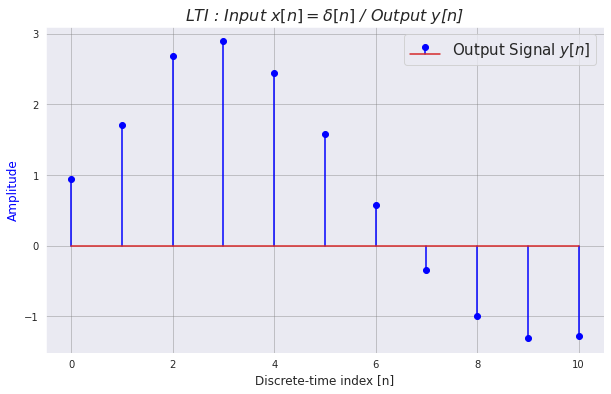

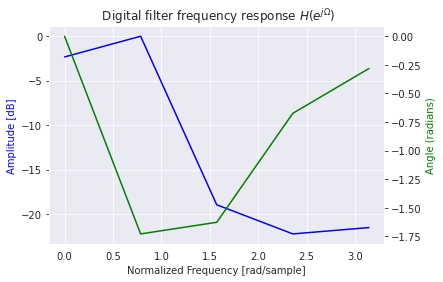

In [7]:
# [*] 2nd METHOD : Simulation✅
## a) x[n] = δ[n], 1 ≤ n ≤ 11
## IMPULSE RESPONSE(time)
L = 11
n = np.arange(L)
x = np.where(n == 0, 1.0, 0)
y = signal.lfilter(b, a, x)
plot_response(y = y, N  = L , dbScale = False, name = "x[n] = δ[n]")
## FREQUENCY RESPONSE(frequency)
Y = np.fft.fft(y)[:L//2]
w = np.linspace(0, np.pi, L//2)
plot_freq_response(w, Y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


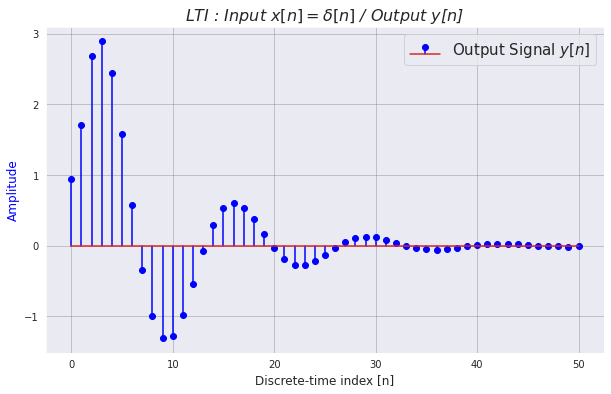

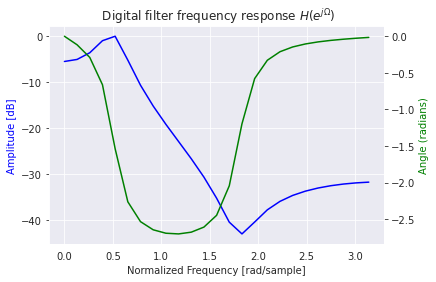

In [8]:
## b) x[n] = δ[n], 1 ≤ n ≤ 51
## IMPULSE RESPONSE(time)
L = 51
n = np.arange(L)
x = np.where(n == 0, 1.0, 0)
y = signal.lfilter(b, a, x)
plot_response(y = y,  N  = L , dbScale = False, name = "x[n] = δ[n]")
## FREQUENCY RESPONSE(frequency)
Y = np.fft.fft(y)[:L//2]
w = np.linspace(0, np.pi, L//2)
plot_freq_response(w, Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


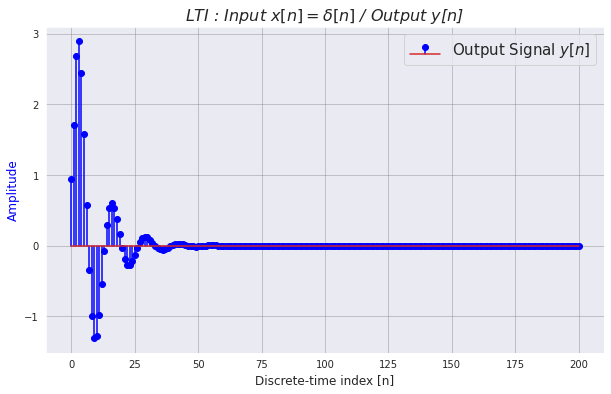

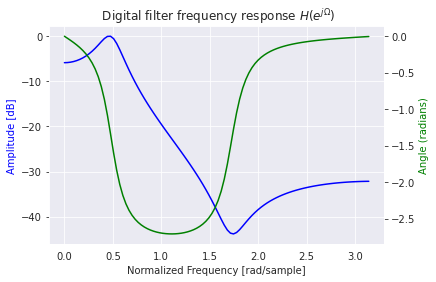

In [9]:
## c) x[n] = δ[n], 1 ≤ n ≤ 201
## IMPULSE RESPONSE(time)
L = 201
n = np.arange(L)
x = np.where(n == 0, 1.0, 0)
y = signal.lfilter(b, a, x)
plot_response(y = y,  N  = L , dbScale = False, name = "x[n] = δ[n]")
## FREQUENCY RESPONSE(frequency)
Y = np.fft.fft(y)[:L//2]
w = np.linspace(0, np.pi, L//2)
plot_freq_response(w, Y)